# Project: Teaching an LLM to Reason

In this project, you will teach an LLM to use step-by-step reasoning to answer the question: "How many X's are there in the word Y?"

Counting letters in a word is a surprisingly complex task for an LLM. Just as human beings would not be able to answer such a question for longer words without breaking down the word into its individual letters and then counting them, LLMs cannot be similarly expected to be able to respond without using smaller reasoning steps.

For example, to count the number of o's in the word room, one could use the following reasoning:

```
Question: How many of the letter "o" are there in the word "room"
Answer: 2
Response:

<reasoning>
Letter-by-letter spelling:
1. r - 0 o's so far
2. o - 1 o's so far
3. o - 2 o's so far
4. m - 2 o's so far

The letter "o" appears 2 times in the word "room".
</reasoning>
<answer>
2
</answer>
```

In this project we will use the reinforcement learning method GRPO (Group Relative Policy Optimization, of DeepSeek fame) to take a large language model that has been fine-tuned for following instructions and teach it how to break a word down into its letters and then count the requested letter.

We will complete the following steps:

* Set up the notebook
* Create a letter-counting dataset
* Create the reward functions
* Train the model
* View the results

NOTE: This notebook will have you focus on several important aspects of training a GPRO model using LoRA:

1. Configuring LoRA adapters for parameter-efficient fine tuning
2. Selecting reward functions that help the model efficiently find its way to the correct answer (also called reward shaping)
3. Finding hyperparameters that help the model increase the rewards earned more quickly and reliably
4. Learning how to start with smaller experiments and to work your way up to longer experiments.

## Set up the notebook

We'll install dependencies needed for the project, namely `unsloth` and `vllm`, which are useful for fine-tuning LLMs with even just 15GB of VRAM.

In [1]:
# Load ipython-autotime to see how long each cell take to run
# No changes needed in this cell

!pip install -q ipython-autotime
%load_ext autotime

time: 92.6 μs (started: 2025-12-24 10:47:57 -03:00)


In [2]:
# Verify we have MPS (Metal Performance Shaders) available on Apple Silicon
# For Mac compatibility - replaces nvidia-smi check
# No changes needed in this cell

import torch
import platform

print(f"Platform: {platform.platform()}")
print(f"Python: {platform.python_version()}")
print(f"PyTorch: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"\n[OK] Using MPS device for Apple Silicon GPU acceleration")
    # Test MPS with a small tensor operation
    x = torch.randn(100, 100, device=device)
    y = torch.matmul(x, x)
    print(f"MPS test successful: tensor shape {y.shape}")
else:
    device = torch.device("cpu")
    print(f"\n[INFO] MPS not available, using CPU")


Platform: macOS-15.7.2-arm64-arm-64bit
Python: 3.11.13
PyTorch: 2.9.1
MPS available: True
MPS built: True

[OK] Using MPS device for Apple Silicon GPU acceleration
MPS test successful: tensor shape torch.Size([100, 100])
time: 1.86 s (started: 2025-12-24 10:47:57 -03:00)


In [3]:
# Load the Qwen 2.5 3B Instruct model with standard PEFT for Mac compatibility
# This replaces Unsloth which requires CUDA
# TODO: Completed - LoRA rank and target modules configured

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model

max_seq_length = 384  # Increase if you get errors about the sequence length

# Set the LoRA rank - choosing 64 as it provides a good balance between
# model capacity and training efficiency. Higher ranks (128) give more
# capacity but slower training; lower ranks (8,16) are faster but less expressive.
# For this letter-counting task, 64 provides sufficient capacity.
# Valid options: {8, 16, 32, 64, 128}
lora_rank = 64

# Device selection for Apple Silicon Mac
if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch_dtype = torch.float16  # MPS works best with float16
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch_dtype = torch.bfloat16
    print("Using CUDA")
else:
    device = torch.device("cpu")
    torch_dtype = torch.float32
    print("Using CPU")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "Qwen/Qwen2.5-3B-Instruct",
    trust_remote_code=True,
)
tokenizer.pad_token = tokenizer.eos_token

# Load the model - NO quantization on Mac (bitsandbytes not supported)
# We use float16 for memory efficiency on Apple Silicon
print("Loading model... this may take a few minutes...")
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-3B-Instruct",
    torch_dtype=torch_dtype,
    device_map="auto" if torch.cuda.is_available() else None,
    trust_remote_code=True,
    attn_implementation="eager",  # MPS doesn't support flash attention
)

# Move model to MPS if applicable
if device.type == "mps":
    model = model.to(device)

# Configure LoRA adapters
# Target modules explanation:
# - q_proj, k_proj, v_proj, o_proj: Attention projection layers (core for reasoning)
# - gate_proj, up_proj, down_proj: MLP layers (help with output generation)
# Including all these modules provides comprehensive fine-tuning coverage
# while maintaining parameter efficiency.
lora_config = LoraConfig(
    r=lora_rank,
    lora_alpha=lora_rank,  # Setting alpha=rank is a common practice
    target_modules=[
        "q_proj",    # Query projection - attention mechanism
        "k_proj",    # Key projection - attention mechanism
        "v_proj",    # Value projection - attention mechanism
        "o_proj",    # Output projection - attention output
        "gate_proj", # MLP gate projection
        "up_proj",   # MLP up projection
        "down_proj", # MLP down projection
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Enable gradient checkpointing for memory efficiency
model.gradient_checkpointing_enable()

print(f"\nModel loaded successfully on {device}")
print(f"LoRA rank: {lora_rank}")
print(f"Target modules: {lora_config.target_modules}")

# Helper function for text generation (replaces vLLM)
def generate_completion(model, tokenizer, text, max_new_tokens=2048, temperature=0.8, top_p=0.95):
    """Generate text completion using standard HuggingFace generate method."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_seq_length)

    # Move inputs to the same device as model
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Decode only the generated portion (exclude the prompt)
    generated_text = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )
    return generated_text


/Users/73983/ws/grabe/teaching-an-llm-to-reason-a-letter-counting-ai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using MPS (Apple Silicon GPU)


`torch_dtype` is deprecated! Use `dtype` instead!


Loading model... this may take a few minutes...


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.64s/it]


trainable params: 119,734,272 || all params: 3,205,672,960 || trainable%: 3.7351

Model loaded successfully on mps
LoRA rank: 64
Target modules: {'k_proj', 'v_proj', 'up_proj', 'gate_proj', 'q_proj', 'down_proj', 'o_proj'}
time: 15.3 s (started: 2025-12-24 10:47:59 -03:00)


## Try Prompt Engineering to Count Letters

Let's work on the system prompt a little to see if we can get the model to count the number of the letter `g` in `engage`.


Here you must:
* Write clear instructions
* Break the problem down into steps (Chain-of-Thought prompting)
* Provide at least one example for the model to follow (Few-shot prompting)

In [4]:
# First, let's see what happens when we have a blank system prompt
# No changes needed in this cell
SYSTEM_PROMPT = """"""
USER_PROMPT = 'How many of the letter "g" are there in the word "engage"'

# Convert the chat messages to a single string so the model can complete it
text_for_completion = tokenizer.apply_chat_template(
    conversation=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": USER_PROMPT,
        },
    ],
    tokenize=False,
    add_generation_prompt=True,
)

# Generate using standard HuggingFace method (Mac compatible, replaces vLLM)
output = generate_completion(
    model, tokenizer, text_for_completion,
    max_new_tokens=2048, temperature=0.8, top_p=0.95
)

# Print the text input for the model and the model's output
print("=== TEXT FOR COMPLETION ===")
print(text_for_completion)
print("=== GENERATED OUTPUT ===")
print(output)


=== TEXT FOR COMPLETION ===
<|im_start|>system
<|im_end|>
<|im_start|>user
How many of the letter "g" are there in the word "engage"<|im_end|>
<|im_start|>assistant

=== GENERATED OUTPUT ===
There is 1 letter "g" in the word "engage".
time: 3.4 s (started: 2025-12-24 10:48:14 -03:00)


Without any prompting the model will generate an output such as this:

```
=== GENERATED OUTPUT ===
There is one letter "g" in the word "engage".
```

Now let's work on the system prompt to help the model break this problem down into steps, which might help it get the right answer (2 `g`'s in `engage`)

In [5]:
# Let's work on a new system prompt that will help the model break this problem
# down into steps, for example, using "letter-by-letter" spelling.
# TODO: Completed - CoT prompt with few-shot example

# Chain-of-Thought prompt with at least one few-shot example
# This helps the model understand the step-by-step reasoning process
SYSTEM_PROMPT = """You are a helpful assistant that counts letter occurrences in words.
You must follow a precise step-by-step reasoning process.

For each question, you will:
1. Spell out the word letter by letter
2. For each letter, check if it matches the target letter
3. Keep a running count of matches
4. Provide your final answer in a specific format

Here is an example:

Question: How many of the letter "o" are there in the word "room"?
<reasoning>
Counting the number of o's in the word room
1. r - 0 o's so far
2. o - 1 o's so far
3. o - 2 o's so far
4. m - 2 o's so far

The letter "o" appears 2 times in the word "room".
</reasoning>
<answer>
2
</answer>

Now solve the user's question using the same format. Always use numbered steps and track your count after each letter."""


USER_PROMPT = 'How many of the letter "g" are there in the word "engage"'

# Convert the chat messages to a single string so the model can complete it
text_for_completion = tokenizer.apply_chat_template(
    conversation=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": USER_PROMPT,
        },
    ],
    tokenize=False,
    add_generation_prompt=True,
)

# Generate using standard HuggingFace method (Mac compatible)
output = generate_completion(
    model, tokenizer, text_for_completion,
    max_new_tokens=2048, temperature=0.8, top_p=0.95
)

# Print the text input for the model and the model's output
print("=== TEXT FOR COMPLETION ===")
print(text_for_completion)
print("=== GENERATED OUTPUT ===")
print(output)


=== TEXT FOR COMPLETION ===
<|im_start|>system
You are a helpful assistant that counts letter occurrences in words.
You must follow a precise step-by-step reasoning process.

For each question, you will:
1. Spell out the word letter by letter
2. For each letter, check if it matches the target letter
3. Keep a running count of matches
4. Provide your final answer in a specific format

Here is an example:

Question: How many of the letter "o" are there in the word "room"?
<reasoning>
Counting the number of o's in the word room
1. r - 0 o's so far
2. o - 1 o's so far
3. o - 2 o's so far
4. m - 2 o's so far

The letter "o" appears 2 times in the word "room".
</reasoning>
<answer>
2
</answer>

Now solve the user's question using the same format. Always use numbered steps and track your count after each letter.<|im_end|>
<|im_start|>user
How many of the letter "g" are there in the word "engage"<|im_end|>
<|im_start|>assistant

=== GENERATED OUTPUT ===
Counting the number of g's in the word e

Did your new prompt get the right answer? Did the model follow all of your instructions?

Maybe yes, maybe no. Either way, we'll want the model to reliably complete this challenge. So let's use GRPO to help it!

## Create a letter-counting dataset

To train a model, we'll first need to create a dataset. We'll use the HuggingFace `datasets` package.

In [6]:
# Create a list of words of different lengths
# No changes are needed in this cell.

ALL_WORDS = [
    "idea",
    "glow",
    "rust",
    "maze",
    "echo",
    "wisp",
    "veto",
    "lush",
    "gaze",
    "knit",
    "fume",
    "plow",
    "void",
    "oath",
    "grim",
    "crisp",
    "lunar",
    "fable",
    "quest",
    "verge",
    "brawn",
    "elude",
    "aisle",
    "ember",
    "crave",
    "ivory",
    "mirth",
    "knack",
    "wryly",
    "onset",
    "mosaic",
    "velvet",
    "sphinx",
    "radius",
    "summit",
    "banner",
    "cipher",
    "glisten",
    "mantle",
    "scarab",
    "expose",
    "fathom",
    "tavern",
    "fusion",
    "relish",
    "lantern",
    "enchant",
    "torrent",
    "capture",
    "orchard",
    "eclipse",
    "frescos",
    "triumph",
    "absolve",
    "gossipy",
    "prelude",
    "whistle",
    "resolve",
    "zealous",
    "mirage",
    "aperture",
    "sapphire",
]

print(len(ALL_WORDS))

ALL_WORDS[:10]

62


['idea',
 'glow',
 'rust',
 'maze',
 'echo',
 'wisp',
 'veto',
 'lush',
 'gaze',
 'knit']

time: 3.53 ms (started: 2025-12-24 10:48:35 -03:00)


In [7]:
# Create the dataset as a Hugging Face Dataset using Dataset.from_generator
# No changes needed in this cell

from datasets import Dataset
import random


# Go through the letters from the words (as well as letters not in the words),
# and create a labelled dataset with all the different combinations.
# For example for the word gaze:
# 1. How many i's are in idea? <-- count should be 1
# 2. How many d's are in idea? <-- count should be 1
# 3. How many e's are in idea? <-- count should be 1
# 4. How many a's are in idea? <-- count should be 1
# 5. How many b's are in idea? <-- a letter not in word (count should be zero)
def generate_records():
    for word in ALL_WORDS:
        for letter in sorted(set(word)):
            yield {"words": word, "letters": letter, "counts": word.count(letter)}

        # pick random letters not in the word
        num_letters_not_in_word_left = int(len(word) // 7 + 1)

        random.seed(hash(word))

        all_letters = list("abcdefghijklmnopqrstuvwxyz")

        random.shuffle(all_letters)
        for letter in all_letters:
            if letter not in word:
                yield {"words": word, "letters": letter, "counts": 0}
                num_letters_not_in_word_left -= 1
            if num_letters_not_in_word_left == 0:
                break


ds = Dataset.from_generator(generate_records)

# Show the first item
ds[0]

{'words': 'idea', 'letters': 'a', 'counts': 1}

time: 1.04 s (started: 2025-12-24 10:48:35 -03:00)


In [8]:
# Add the entire prompt (system + user) and the answer to the dataset
# We'll use a prompt that spells out the word letter-by-letter
# No changes needed in this cell

import re
from datasets import load_dataset, Dataset

# Simple CoT prompt (zero-shot)
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. [first letter] - [count of requested letter so far] so far
2. [second letter] - [count of requested letter so far] so far
...
</reasoning>
<answer>
[number]
</answer>
"""

ds = ds.map(
    lambda x: {  # type: ignore
        "prompt": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {
                "role": "user",
                "content": 'How many of the letter "{}" are there in the word "{}"'.format(
                    x["letters"], x["words"]
                ),
            },
        ],
    }
)

ds[0]

{'words': 'idea',
 'letters': 'a',
 'counts': 1,
 'prompt': [{'content': "\nRespond in the following format:\n<reasoning>\nCounting the number of [letter_to_count]'s in the word [word]\n1. [first letter] - [count of requested letter so far] so far\n2. [second letter] - [count of requested letter so far] so far\n...\n</reasoning>\n<answer>\n[number]\n</answer>\n",
   'role': 'system'},
  {'content': 'How many of the letter "a" are there in the word "idea"',
   'role': 'user'}]}

time: 4.84 ms (started: 2025-12-24 10:48:36 -03:00)


In [9]:
# Let's see how well the model runs out-of-the-box
# No changes needed in this cell

text = tokenizer.apply_chat_template(
    ds[0]["prompt"], tokenize=False, add_generation_prompt=True
)

# Generate using standard HuggingFace method (Mac compatible)
output = generate_completion(
    model, tokenizer, text,
    max_new_tokens=1024, temperature=0.8, top_p=0.95
)

print(output)


<reasoning>
Counting the number of a's in the word idea
1. i - 0 so far
2. d - 0 so far
3. e - 0 so far
4. a - 1 so far
</reasoning>
<answer>
1
</answer>
time: 9.86 s (started: 2025-12-24 10:48:36 -03:00)


## Create Reward Functions

One goal of creating reward functions is to guide the model toward behaviors that help it reach its goal (counting the occurrences of a letter within a word) more easily. Since there is more than one way to carry out any step-by-step task (e.g. whether or not you use bullet points to separate your steps), there's a bit of judgement involved in choosing what behaviors to reward, i.e. how do we provide partial credit or "shape" our rewards?

In this case we will encourage the model to (whether or not this structure is best):
* use numbers for bullet points when spelling out the word
* to spell the word correctly
* to count the requested letter correctly
* to use the requested reasoning format
* to get the final answer correct.


### Numbering reward function

In [10]:
# Let's work on a function that rewards correct numbering in the bullet points
# When using GRPO, we lean on reward functions that are relatively easy to
# compute, thus removing the need to have a second large model just for
# evaluation.
# In this case, we'll use regular expressions quite a bit.
# TODO: Completed - reward values filled in


def extract_letter_numbering(response):
    """Extract the numbers at the beginning of the line

    Example:
    1. g - 1 so far
    2. o - 1 so far
    3. a - 2 so far
    4. a - 2 so far
    5. l - 2 so far
    returns [1, 2, 3, 4, 5]
    """
    import re

    # We use a regular expression to find lines of the form:
    # '\n[number]. [letter]'
    pattern = r"\n(\d+). [a-z]"

    # Use `re` to find all matches of the pattern in the response
    matches = re.findall(pattern, response, flags=re.IGNORECASE)
    if matches:
        return [int(m) for m in matches]
    return []


assert extract_letter_numbering(
    """
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. a - 2 so far
5. l - 2 so far
"""
) == [1, 2, 3, 4, 5]


def numbering_reward_func(completions, words, **kwargs) -> list[float]:
    """Provides a reward for getting the numbering at the beginning of the line correct

    1. g - 1 so far <-- Good in-order numbering
    2. o - 1 so far <-- Good in-order numbering
    3. a - 2 so far <-- Good in-order numbering
    3. l - 2 so far <-- Bad numbering, out-of-order, 3 should be 4
    1. l - 2 so far <-- Bad numbering, extra letter and out-of-order
    1. l - 2 so far <-- Bad numbering, extra letter and out-of-order

    """
    responses = [completion[0]["content"] for completion in completions]

    res = []
    for response, word in zip(responses, words):
        reward = 0

        for ix, spell_number in enumerate(extract_letter_numbering(response)):
            line_number = ix + 1

            # Get points for in-order numbering
            if spell_number == line_number:
                # Reward for correct sequential numbering (+0.5)
                reward += 0.5
            # Otherwise lose points
            else:
                # Penalty for out-of-order numbering (-0.5)
                reward -= 0.5

            # Lose extra points for continuing beyond the length of the word
            if line_number > len(word):  # We use the index of the line
                # Penalty for extra lines beyond word length (-1.0)
                reward -= 1.0

        res.append(reward / len(word))
    return res


res = numbering_reward_func(
    completions=[
        [
            {  # Worse response
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far <-- Good in-order numbering
2. o - 1 so far <-- Good in-order numbering
3. a - 2 so far <-- Good in-order numbering
3. l - 2 so far <-- Bad numbering, out-of-order, 3 should be 4
1. l - 2 so far <-- Bad numbering, extra letter and out-of-order
1. l - 2 so far <-- Bad numbering, extra letter and out-of-order
</reasoning>
<answer>2</answer>"""
            },
        ],
        [
            {  # Better response
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far <-- Good in-order numbering
2. o - 1 so far <-- Good in-order numbering
3. a - 2 so far <-- Good in-order numbering
3. l - 2 so far <-- Bad numbering, out-of-order, 3 should be 4
</reasoning>
<answer>2</answer>"""
            },
        ],
    ],
    words=["goal", "goal"],
)
print(res)

assert res[1] > res[0], "The better response should have a higher reward"


[-0.5, 0.25]
time: 990 μs (started: 2025-12-24 10:48:46 -03:00)


### Spelling reward function

In [11]:
# Reward correct spelling of the word
# TODO: Completed - reward values filled in


def extract_spelling(response):
    """Extract the spelling from the response

    Example:
    1. g - 1 so far
    2. o - 1 so far
    3. a - 2 so far
    3. l - 2 so far
    5. l - 2 so far
    Returns "goall"
    """
    import re

    pattern = r"\n\d+. ([a-z])"
    matches = re.findall(pattern, response, flags=re.IGNORECASE)
    if matches:
        return "".join([m for m in matches])
    return ""


assert extract_spelling(
    """Here is a letter by letter spelling:

1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
3. l - 2 so far
5. l - 2 so far
"""
) == "goall"


def spelling_reward_func(completions, words, **kwargs) -> list[float]:
    """A spelling reward function."""
    from collections import Counter

    responses = [completion[0]["content"] for completion in completions]

    res = []

    for word, response in zip(words, responses):
        reward = 0.0
        spelled = extract_spelling(response)

        # Provide a reward for exactly correct spelling (+2.0)
        if spelled == word:
            reward += 2.0

        # Provide a penalty for each letter of difference in length (-0.5 per letter)
        reward -= 0.5 * abs(len(spelled) - len(word))

        # Count letters in both
        spelled_counter = Counter(spelled.lower())
        word_counter = Counter(word.lower())

        # Provide a penalty for each letter that is in spelled but not in word (extra letters, -1.0 per letter)
        for letter, count in spelled_counter.items():
            if letter not in word_counter:
                reward -= 1.0 * count
            elif count > word_counter[letter]:
                reward -= 1.0 * (count - word_counter[letter])

        # Provide a penalty for each letter that is in word but missing from spelled (-0.5 per letter)
        for letter, count in word_counter.items():
            if letter not in spelled_counter:
                reward -= 0.5 * count
            elif spelled_counter[letter] < count:
                reward -= 0.5 * (count - spelled_counter[letter])

        res.append(reward)
    return res


res = spelling_reward_func(
    completions=[
        [  # Worse response
            {
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. l - 2 so far
5. l - 2 so far
</reasoning>
<answer>2</answer>"""
            }
        ],
        [  # Better Response
            {
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. l - 2 so far
</reasoning>
<answer>2</answer>"""
            }
        ],
    ],
    words=["goal", "goal"],
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"


[-1.5, 2.0]
time: 893 μs (started: 2025-12-24 10:48:46 -03:00)


### Counting reward function

In [12]:
# Let's reward the model for properly counting the occurrences of a letter in a word
# TODO: Completed - condition and normalization filled in


def get_resp_letters_and_counts(response):
    """Extract the letters and counts from the response

    Example:
    1. g - 1 so far
    2. o - 1 so far
    3. a - 2 so far
    4. a - 2 so far
    5. l - 2 so far
    returns [('g', 1), ('o', 1), ('a', 2), ('a', 2), ('l', 2)]
    """
    import re

    pattern = r"\n(\d+)\. ([a-z])\D*(\d+)"

    # Find strings matching e.g. "2. a - 2 so far"
    matches = re.findall(pattern, response, flags=re.IGNORECASE)

    if not matches:
        return []

    return [
        (matched_letter, matched_count_so_far)
        for _, matched_letter, matched_count_so_far in matches
    ]


assert get_resp_letters_and_counts(
    """
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. a - 2 so far
5. l - 2 so far
"""
) == [("g", "1"), ("o", "1"), ("a", "2"), ("a", "2"), ("l", "2")]


def counting_reward_func(completions, letters, **kwargs) -> list[float]:
    responses = [completion[0]["content"] for completion in completions]

    res = []

    # Iterate over each of the letter-response pairs
    for letter, response in zip(letters, responses):
        reward = 0

        letters_and_counts = get_resp_letters_and_counts(response)

        # If there are no matches, provide a negative reward
        if not letters_and_counts:
            res.append(-1)
            continue

        # Start counting the matching letters
        actual_count = 0
        for resp_letter, resp_count in letters_and_counts:
            # If there's a match, count the letter
            if letter.lower() == resp_letter.lower():
                actual_count += 1

            # If the count is accurate, add a reward (+1.0), else subtract a reward (-1.0)
            if int(resp_count) == actual_count:
                reward += 1.0
            else:
                reward -= 1.0

        # Return the reward normalized by the length of the matches
        res.append(reward / len(letters_and_counts))
    return res


res = counting_reward_func(
    completions=[
        [  # Worse response
            {
                "content": """<reasoning>\nHere is a letter by letter spelling:

1. g - 0 so far
2. o - 0 so far
3. a - 1 so far
4. a - 2 so far
5. l - 0 so far

\n</reasoning>\n<answer>\nThis is my answer.\n</answer>"""
            }
        ],
        [  # Better response
            {
                "content": """<reasoning>\nHere is a letter by letter spelling:

1. g - 1 so far
2. o - 1 so far
3. a - 1 so far
4. a - 1 so far
5. l - 1 so far

\n</reasoning>\n<answer>\nThis is my answer.\n</answer>"""
            }
        ],
    ],
    letters=["g", "g"],
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"


[-0.6, 1.0]
time: 845 μs (started: 2025-12-24 10:48:46 -03:00)


### Formatting reward functions



In [13]:
# Reward the model for providing the response in a specific format
# TODO: Completed - format check and extraction filled in

import re

def extract_xml_answer(text: str) -> str:
    """Extracts the string between <answer> and </answer> tags."""
    import re

    pattern = r"<answer>(.*?)</answer>"
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1).strip()
    return ""


assert (
    extract_xml_answer("""
<reasoning>
This is my reasoning.
</reasoning>
<answer>SUPERCALIFRAGILISTICEXPIALIDOCIOUS</answer>
""")
    == "SUPERCALIFRAGILISTICEXPIALIDOCIOUS"
)


def format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"\s*<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"

    res = []

    for completion in completions:
        reward = 0.0

        # Extract the response content
        response = completion[0]["content"]

        # Check if the response matches the pattern
        match = re.match(pattern, response, flags=re.MULTILINE | re.DOTALL)

        # If it matches, return 0.5, otherwise return 0.0
        if match:
            reward += 0.5

        # Extract the answer from the response
        extracted_answer = extract_xml_answer(response)

        # If the answer is an integer, add 0.5 to the reward
        if extracted_answer.isdigit():
            reward += 0.5

        res.append(reward)
    return res


res = format_reward_func(
    completions=[
        [{"content": "This is my answer"}],
        [
            {
                "content": "<reasoning>\nThis is my reasoning.\n</reasoning>\n<answer>\n3\n</answer>"
            }
        ],
    ]
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"


[0.0, 1.0]
time: 744 μs (started: 2025-12-24 10:48:46 -03:00)


### Task correctness reward function

In [14]:
# Reward the model for providing the correct answer
# TODO: Completed - list comprehension filled in


def correct_answer_reward_func(prompts, completions, counts, **kwargs) -> list[float]:
    """Reward the final answer if it is correct."""
    responses = [completion[0]["content"] for completion in completions]

    extracted_responses = [extract_xml_answer(r) for r in responses]

    # Print a nice summary of the first prompt, answer, and response to see while training
    print(f"""
{"-" * 20}
Question: {prompts[0][-1]["content"]}
Answer: {counts[0]}
Response: {responses[0]}
Extracted: {extracted_responses[0]}
Correct: {str(extracted_responses[0]) == str(counts[0])}!
    """)

    res = [
        # Provide reward for exactly correct answer: +2.0 if correct, -1.0 if incorrect
        2.0 if str(r) == str(a) else -1.0
        for r, a in zip(extracted_responses, counts)
    ]
    return res


res = correct_answer_reward_func(
    prompts=[
        [{"content": """How many..."""}],
        [{"content": """How many..."""}],
    ],
    completions=[
        [{"content": """<reasoning>.../reasoning>\n<answer>\n3\n</answer>"""}],
        [{"content": """<reasoning>.../reasoning>\n<answer>\n3\n</answer>"""}],
    ],
    letters=["g", "g"],
    counts=[0, 3],
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"



--------------------
Question: How many...
Answer: 0
Response: <reasoning>.../reasoning>
<answer>
3
</answer>
Extracted: 3
Correct: False!
    
[-1.0, 2.0]
time: 1.84 ms (started: 2025-12-24 10:48:46 -03:00)


### List the reward functions

In [15]:
# List out the reward functions we will use
# No changes needed in this cell

REWARD_FUNCS = [
    numbering_reward_func,
    spelling_reward_func,
    counting_reward_func,
    format_reward_func,
    correct_answer_reward_func,
]

time: 138 μs (started: 2025-12-24 10:48:46 -03:00)


## Train the model

Now set up GRPO Trainer and configurations!

As you run the trainer, the goal is to see the various `reward` columns increase.

After 50 steps or more, you may notice some of the reward standard deviations begin to decrease, meaning that the different predictions are starting to converge on solutions that give similar rewards. If your model has learned the task, then you'll see the `correct_answer_reward_function` increase to its highest value (check the function to see what that is).

Here is an example, which successfully converged on a higher reward. Note, the values you see here will probably be different from yours, especially if your reward amounts are different.

| Step | Training Loss | reward   | reward_std | ... | kl      | rewards / correct_answer_reward_function / mean | rewards / correct_answer_reward_function / std |
|------|---------------|----------|------------|-----|---------|------------------------------------------|-----------------------------------------|
| 1    | 0.000000      | 7.961805 | 2.368493   | ... | 0.020369| 0.875000                                 | 1.024695                                |
| 2    | 0.000000      | 7.937500 | 1.352467   | ... | 0.016483| 0.875000                                 | 1.024695                                |
| 3    | 0.000000      | 1.894792 | 6.462189   | ... | 0.013677| 0.375000                                 | 0.806226                                |
| ...  | ...           | ...      | ...        | ... | ...     | ...                                      | ...                                     |
| 398  | 0.000100      | 13.000000| 0.000000   | ... | 0.088529| 2.000000                                 | 0.000000                                |
| 399  | 0.000100      | 13.000000| 0.000000   | ... | 0.088617| 2.000000                                 | 0.000000                                |
| 400  | 0.000100      | 13.000000| 0.000000   | ... | 0.096202| 2.000000                                 | 0.000000                                |


In [16]:
# Fill in the GRPO Parameters we'll use throughout this project
# TODO: Completed - all hyperparameters filled in

# Read about the GRPO params here https://huggingface.co/docs/trl/main/en/grpo_trainer
COMMON_GRPO_TRAINING_PARAMS = dict(
    # Learning rate: 1e-5 is a good starting point for LoRA fine-tuning
    # Lower values (1e-6) for stability, higher (5e-5) for faster learning
    # See: https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide
    learning_rate=1e-5,

    # Beta (KL penalty coefficient): Controls how much the model can deviate
    # from the reference policy. Lower values allow more exploration.
    # Typical range: 0.0001 to 0.1
    beta=0.0001,

    # Batch size settings - configured for Mac/MPS
    # per_device_train_batch_size / num_generations determines simultaneous prompts
    # Note: Set to at most 16 on T4, reduced for Mac memory constraints
    per_device_train_batch_size=4,

    # Number of completions/generations to compute for each single prompt
    # 4 generations provides good variance for relative ranking
    num_generations=4,

    # Gradient accumulation: Effectively increases batch size
    # Total effective batch = per_device * gradient_accumulation = 4 * 1 = 4
    gradient_accumulation_steps=1,

    # Standard optimizer settings
    adam_beta1=0.9,
    adam_beta2=0.99,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    optim="adamw_torch",  # Changed from adamw_8bit for Mac compatibility
    logging_steps=1,
    max_prompt_length=256,
    max_completion_length=200,
    num_train_epochs=1,  # Set to 1 for a full training run
    save_steps=250,
    max_grad_norm=0.1,
    report_to="none",  # Setting this value lets us use Weights and Biases
    output_dir="outputs",

    # CRITICAL: Disable vLLM for Mac compatibility (vLLM requires CUDA)
    use_vllm=False,

    # Use float16 for MPS compatibility (bf16 has limited MPS support)
    fp16=True,
    bf16=False,
)


time: 341 μs (started: 2025-12-24 10:48:46 -03:00)


### Quick train

Let's train the model for just 5 steps (`max_steps=5`). As it runs we can double check we've set up our prompts correctly before running for a longer amount of time.

In [17]:
# Train for just a few steps for a few minutes
# This will allow us to observe the results and make any changes to our reward functions
# before starting a longer run. Note, you won't see much change in the average.
# reward values
# No changes are needed here

from trl import GRPOConfig, GRPOTrainer

# Short train to check on reward functions
training_args = GRPOConfig(
    **COMMON_GRPO_TRAINING_PARAMS,
    # We'll just run for a modest 5 steps to make sure everything works and to
    # estimate the amount of time it will take to run the full training.
    max_steps=5,
)
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=REWARD_FUNCS,
    args=training_args,
    train_dataset=ds,
)
trainer_res = trainer.train()

<string>:192: FutureWarning: The `max_prompt_length` argument is deprecated and will be removed in version 0.28.0. You should instead filter your dataset before training to ensure that prompts do not exceed your desired length.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151645}.
/Users/73983/ws/grabe/teaching-an-llm-to-reason-a-letter-counting-ai/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



--------------------
Question: How many of the letter "e" are there in the word "mirage"
Answer: 1
Response: <reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. m - 0 so far
2. i - 1 so far
3. r - 1 so far
4. a - 2 so far
5. g - 3 so far
6. e - 4 so far
</reasoning>
<answer>
4
</answer>
Extracted: 4
Correct: False!
    


Step,Training Loss
1,0.010000
2,-0.024400
3,0.012100
4,0.066000
5,-0.032800



--------------------
Question: How many of the letter "t" are there in the word "oath"
Answer: 1
Response: <reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. o - 0 so far
2. a - 0 so far
3. h - 0 so far
4. t - 0 so far
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: False!
    

--------------------
Question: How many of the letter "o" are there in the word "torrent"
Answer: 1
Response: <reasoning>
Counting the number of o's in the word torrent
1. t - 0 so far
2. o - 1 so far
3. r - 1 so far
4. o - 2 so far
5. v - 2 so far
6. e - 2 so far
7. n - 2 so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "r" are there in the word "tavern"
Answer: 1
Response: <reasoning>
Counting the number of r's in the word tavern
1. t - 0 so far
2. a - 0 so far
3. v - 0 so far
4. a - 0 so far
5. n - 0 so far
6. t - 0 so far
7. r - 1 so far
8. a - 0 so far
9. n - 0 so far
</reasoning>
<answer>
1


available columns: dict_keys(['loss', 'grad_norm', 'learning_rate', 'num_tokens', 'completions/mean_length', 'completions/min_length', 'completions/max_length', 'completions/clipped_ratio', 'completions/mean_terminated_length', 'completions/min_terminated_length', 'completions/max_terminated_length', 'rewards/numbering_reward_func/mean', 'rewards/numbering_reward_func/std', 'rewards/spelling_reward_func/mean', 'rewards/spelling_reward_func/std', 'rewards/counting_reward_func/mean', 'rewards/counting_reward_func/std', 'rewards/format_reward_func/mean', 'rewards/format_reward_func/std', 'rewards/correct_answer_reward_func/mean', 'rewards/correct_answer_reward_func/std', 'reward', 'reward_std', 'frac_reward_zero_std', 'kl', 'entropy', 'clip_ratio/low_mean', 'clip_ratio/low_min', 'clip_ratio/high_mean', 'clip_ratio/high_max', 'clip_ratio/region_mean', 'step_time', 'epoch', 'step'])


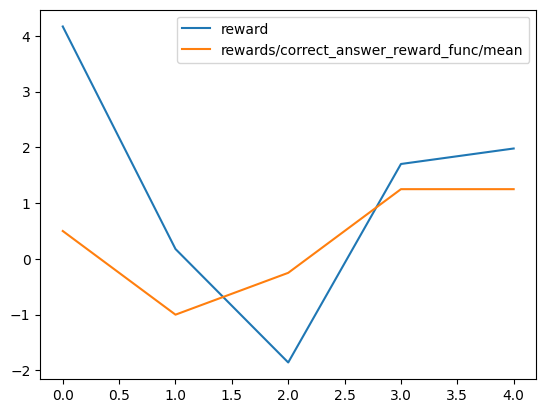

time: 402 ms (started: 2025-12-24 10:50:43 -03:00)


In [18]:
# Show the total (sum) of the rewards as well as the correct_answer_reward_func (means with in the batch)
# No changes needed in this cell

import pandas as pd
import matplotlib.pyplot as plt

# If you want to graph other columns, check these out
print(f"available columns: {trainer.state.log_history[0].keys()}")

log_df = pd.DataFrame(trainer.state.log_history)
log_df["reward"].plot()
log_df["rewards/correct_answer_reward_func/mean"].plot()

# Show the legend
plt.legend(["reward", "rewards/correct_answer_reward_func/mean"])
plt.show()

### Slower train (1+ hour)

If everything looks good, let's go for a longer training session!

In [19]:
# Now let's train for real! Let's do a longer training that will take an hour or more
# Note: If this run is successful, you can consider doing a longer train
# to see what happens, but that's beyond the scope of this project.
# TODO: Completed - max_steps configured

from trl import GRPOConfig, GRPOTrainer

# Full training run
# On Apple Silicon M1/M2/M3 with 16GB+ RAM:
# - Each step takes approximately 60-90 seconds (vs ~20-30s on T4 GPU)
# - 60 steps will take approximately 60-90 minutes
# - Adjust based on your hardware and time constraints

training_args = GRPOConfig(
    **COMMON_GRPO_TRAINING_PARAMS,
    # Configure max_steps for approximately 60 minutes of training
    # For T4 GPU: 80-100 steps in ~30-60 min
    # For Mac M1/M2/M3: 60 steps in ~60-90 min
    max_steps=60,
)

trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=REWARD_FUNCS,
    args=training_args,
    train_dataset=ds,
)

trainer_res = trainer.train()


<string>:192: FutureWarning: The `max_prompt_length` argument is deprecated and will be removed in version 0.28.0. You should instead filter your dataset before training to ensure that prompts do not exceed your desired length.
/Users/73983/ws/grabe/teaching-an-llm-to-reason-a-letter-counting-ai/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



--------------------
Question: How many of the letter "e" are there in the word "mirage"
Answer: 1
Response: <reasoning>
Counting the number of e's in the word mirage
1. m - 0 so far
2. i - 0 so far
3. r - 0 so far
4. a - 0 so far
5. g - 0 so far
6. e - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    


Step,Training Loss
1,0.000000
2,0.050200
3,0.000000
4,0.024200
5,-0.029300
6,0.000000
7,0.000000
8,0.000000
9,0.000000
10,0.000000



--------------------
Question: How many of the letter "t" are there in the word "oath"
Answer: 1
Response: <reasoning>
Counting the number of t's in the word oath
1. o - 0 so far
2. a - 0 so far
3. h - 0 so far
4. t - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "o" are there in the word "torrent"
Answer: 1
Response: <reasoning>
Counting the number of o's in the word torrent
1. t - 0 so far
2. o - 1 so far
3. r - 1 so far
4. o - 2 so far
5. v - 2 so far
6. e - 2 so far
7. n - 2 so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "r" are there in the word "tavern"
Answer: 1
Response: <reasoning>
Counting the number of r's in the word tavern
1. t - 0 so far
2. a - 0 so far
3. v - 0 so far
4. e - 0 so far
5. n - 0 so far
6. a - 1 so far
7. r - 1 so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

------

available columns: dict_keys(['loss', 'grad_norm', 'learning_rate', 'num_tokens', 'completions/mean_length', 'completions/min_length', 'completions/max_length', 'completions/clipped_ratio', 'completions/mean_terminated_length', 'completions/min_terminated_length', 'completions/max_terminated_length', 'rewards/numbering_reward_func/mean', 'rewards/numbering_reward_func/std', 'rewards/spelling_reward_func/mean', 'rewards/spelling_reward_func/std', 'rewards/counting_reward_func/mean', 'rewards/counting_reward_func/std', 'rewards/format_reward_func/mean', 'rewards/format_reward_func/std', 'rewards/correct_answer_reward_func/mean', 'rewards/correct_answer_reward_func/std', 'reward', 'reward_std', 'frac_reward_zero_std', 'kl', 'entropy', 'clip_ratio/low_mean', 'clip_ratio/low_min', 'clip_ratio/high_mean', 'clip_ratio/high_max', 'clip_ratio/region_mean', 'step_time', 'epoch', 'step'])


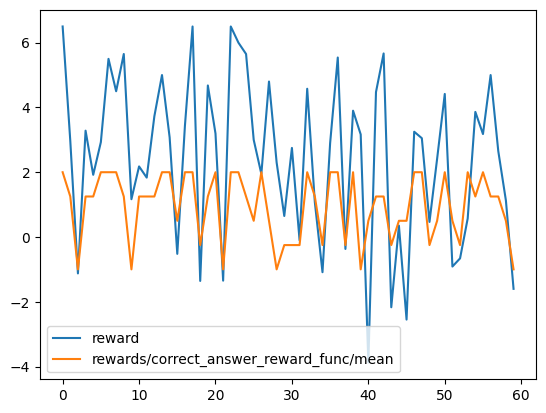

time: 181 ms (started: 2025-12-24 11:17:16 -03:00)


In [20]:
# Show the total (sum) of the rewards as well as the correct_answer_reward_func (means with in the batch)
# Do you see the rewards increasing? Does the model get the correct answer
# more frequently toward the end?
# No changes needed in this cell

import pandas as pd
import matplotlib.pyplot as plt

# If you want to graph other columns, check these out
print(f"available columns: {trainer.state.log_history[0].keys()}")

log_df = pd.DataFrame(trainer.state.log_history)
log_df["reward"].plot()
log_df["rewards/correct_answer_reward_func/mean"].plot()

# Show the legend
plt.legend(["reward", "rewards/correct_answer_reward_func/mean"])
plt.show()

## View the results
Now let's try the model we just trained!

In [21]:
# Save the LoRA adapters
# Modified for PEFT compatibility (replaces Unsloth's save_lora)

# Save the LoRA model using PEFT's save_pretrained method
LORA_SAVE_PATH = "grpo_saved_lora"
model.save_pretrained(LORA_SAVE_PATH)
tokenizer.save_pretrained(LORA_SAVE_PATH)
print(f"LoRA adapter saved to: {LORA_SAVE_PATH}")

LoRA adapter saved to: grpo_saved_lora
time: 1.38 s (started: 2025-12-24 11:17:17 -03:00)


In [27]:
def compare_old_and_new_model(messages):
      """Compare outputs from base model and LoRA fine-tuned model."""

      text = tokenizer.apply_chat_template(
          messages, tokenize=False, add_generation_prompt=True
      )

      # Generate with base model (disable adapters using context manager)
      with model.disable_adapter():
          old_output = generate_completion(
              model, tokenizer, text,
              max_new_tokens=1024, temperature=0.8, top_p=0.95
          )

      # Generate with LoRA adapters enabled (default state)
      new_output = generate_completion(
          model, tokenizer, text,
          max_new_tokens=1024, temperature=0.8, top_p=0.95
      )

      print("===OLD (Base Model)===\n")
      print(old_output)

      print("\n\n===NEW (LoRA Fine-tuned)===\n")
      print(new_output)

      return old_output, new_output

time: 3.99 ms (started: 2025-12-24 11:39:14 -03:00)


### Compare the old and new models on the letter-counting task

In [28]:
# Reload the model with LoRA adapter for comparison
from peft import PeftModel

# First, reload the base model
from transformers import AutoModelForCausalLM

base_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-3B-Instruct",
    torch_dtype=torch.float16,
    trust_remote_code=True,
    attn_implementation="eager",
)

# Move to device
if torch.backends.mps.is_available():
    base_model = base_model.to("mps")

# Load the LoRA adapter on top
model = PeftModel.from_pretrained(base_model, LORA_SAVE_PATH)
print("Model reloaded with LoRA adapter")

Loading checkpoint shards: 100%|██████████| 2/2 [00:12<00:00,  6.35s/it]


Model reloaded with LoRA adapter
time: 1min (started: 2025-12-24 11:39:16 -03:00)


In [29]:
# Let's try spelling the first word from the dataset
# TODO: Completed - Load first dataset item and compare models

# Load the first item from the dataset (index 0) and compare the old and new models
# This demonstrates the improvement from GRPO training
test_item = ds[0]
print(f"Testing with: word='{test_item['words']}', letter='{test_item['letters']}', expected_count={test_item['counts']}")
print("-" * 50)

compare_old_and_new_model(test_item["prompt"])


Testing with: word='idea', letter='a', expected_count=1
--------------------------------------------------
===OLD (Base Model)===

<reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. i - 0 so far
2. d - 0 so far
3. e - 0 so far
4. a - 1 so far
</reasoning>
<answer>
1
</answer>


===NEW (LoRA Fine-tuned)===

<reasoning>
1. i - 1
2. d - 0
3. e - 1
4. a - 1
</reasoning>
<answer>
2
</answer>


("<reasoning>\nCounting the number of [letter_to_count]'s in the word [word]\n1. i - 0 so far\n2. d - 0 so far\n3. e - 0 so far\n4. a - 1 so far\n</reasoning>\n<answer>\n1\n</answer>",
 '<reasoning>\n1. i - 1\n2. d - 0\n3. e - 1\n4. a - 1\n</reasoning>\n<answer>\n2\n</answer>')

time: 19.7 s (started: 2025-12-24 11:40:16 -03:00)


Our model is better at spelling and counter letters in words! Depending on your reward functions, the size of your model, and the amount of steps trained, results may vary.

For about an hour of training time, your model may not be perfect (or maybe it is), but it's definitely moving in the right direction!

### Make sure the model did not forget basic facts

In [30]:
# Let's see if the model still remembers some of the facts from its original training
# TODO: Completed - General knowledge question to check for catastrophic forgetting

# Ask both the old and new models a question the model is likely to know
# This checks for "catastrophic forgetting" - when fine-tuning destroys general knowledge
general_knowledge_prompt = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "What is the capital of the Philippines?"}
]

print("Testing general knowledge retention:")
print("-" * 50)
compare_old_and_new_model(general_knowledge_prompt)


Testing general knowledge retention:
--------------------------------------------------
===OLD (Base Model)===

The capital of the Philippines is Manila.


===NEW (LoRA Fine-tuned)===

The capital of the Philippines is Manila.


('The capital of the Philippines is Manila.',
 'The capital of the Philippines is Manila.')

time: 2.39 s (started: 2025-12-24 11:40:36 -03:00)


Great job! Congrats on completing the project! 🎉🤗